In [2]:
import requests

# 다운로드할 URL
train_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
test_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

# 파일 다운로드 및 저장 함수
def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)

# 파일 다운로드
download_file(train_url, "../data/ratings_train.txt")
download_file(test_url, "../data/ratings_test.txt")

In [8]:
import pandas as pd
train = pd.read_table('../data/ratings_train.txt', sep = '\t')
train = train.drop(columns=['id'])
test = pd.read_table('../data/ratings_test.txt', sep = '\t')
test = test.drop(columns=['id'])

In [9]:
print(train.isna().sum())
print(test.isna().sum())
print("-"*15)
train = train.dropna(how='any')
test = test.dropna(how='any')

print(train.isna().sum())
print(test.isna().sum())

document    5
label       0
dtype: int64
document    3
label       0
dtype: int64
---------------
document    0
label       0
dtype: int64
document    0
label       0
dtype: int64


In [10]:
print(len(train), len(test))
total_sentences = list(train['document']) + list(test['document'])

149995 49997


In [11]:
# pos_tags = [
#     "Noun",       # 명사
#     "Verb",       # 동사
#     "Adjective",  # 형용사
#     "Adverb",     # 부사
#     "Determiner", # 관형사
#     "Exclamation",# 감탄사
#     "Josa",       # 조사
#     "PreEomi",    # 선어말어미
#     "Eomi",       # 어미
#     "Conjunction",# 접속사
#     "Noun",       # 명사
#     "Suffix",     # 접미사
#     "VerbPrefix", # 동사 접두사
#     "Alpha",      # 알파벳
#     "Number",     # 숫자
#     "Foreign",    # 외국어
#     "Punctuation",# 구두점
#     "Hashtag",    # 해시태그
#     "KoreanParticle", # 한국어 입자
#     "ScreenName", # 스크린 이름
#     "Email",      # 이메일 주소
#     "URL"         # URL
# ]

In [12]:
from konlpy.tag import Okt
import numpy as np
import re
from konlpy.tag import Okt

def text_preprocessing(corpus, lang, stop_words=None, tokenizer=None, pos_tags=None):
    """
    This is a text preprocessing function. It processes the given list of texts (corpus) by removing stopwords and performing POS tagging based on the specified language.

    Parameters:
    - corpus (list of str): A list of texts to be preprocessed.
    - lang (str): Specifies the language of the text. Must be either 'eng' or 'kor'.
        - 'eng': Preprocesses English texts.
        - 'kor': Preprocesses Korean texts.
    - stop_words (list of str, optional): A list of stopwords to be removed. Default is None.
    - tokenizer (Okt, optional): A Korean tokenizer (morphological analyzer) object, primarily using Okt. Default is None.
        - Not used when 'lang' is 'eng'.
        - If 'lang' is 'kor' and no tokenizer is provided, an Okt object will be automatically created.
    - pos_tags (list of str, optional): A list of POS tags to filter when processing Korean texts.
        - If provided, only the specified POS tags will be retained. Default is None.

    Returns:
    - list of str: A list of preprocessed texts.
    """
    if lang == 'eng':
        cleaned_corpus = [re.sub(r'[^a-zA-Z ]', '', text).lower() for text in corpus]
        results = []
        if stop_words:
            for text in cleaned_corpus:
                filtered_text = ' '.join(word for word in text.split() if word not in stop_words)
                results.append(filtered_text)
        else:
            results = cleaned_corpus
                
    elif lang == 'kor':
        if tokenizer is None:
            tokenizer = Okt()
            
        cleaned_corpus = [re.sub(r'[^가-힣 ]', '', text).lower() for text in corpus]
        results = []
        if stop_words or pos_tags:
            for text in cleaned_corpus:
                morphs_with_pos = tokenizer.pos(text)
                filtered_morphs = [
                    word for word, pos in morphs_with_pos 
                    if (pos_tags is None or pos in pos_tags) and (word not in stop_words if stop_words else True)
                ]
                filtered_text = ' '.join(filtered_morphs)
                results.append(filtered_text)
        else:
            for text in cleaned_corpus:
                filtered_text = ' '.join(tokenizer.morphs(text))
                results.append(filtered_text)
                
    else:
        raise ValueError("The 'lang' parameter must be either 'eng' or 'kor'.")
                
    return results


lang = 'kor'
stop_words = ['은', '는', '이','가', '을', '를,' '에게', '또','이다', '는', '이', '될']
pos_tags = ["Noun", "Verb","Adjective","Determiner"]
total_sentences = text_preprocessing(corpus=total_sentences, lang='kor', stop_words=stop_words, pos_tags=pos_tags)
train_sentences, test_sentences = total_sentences[:len(train)], total_sentences[len(train):]

In [13]:
train_sentences, test_sentences = total_sentences[:len(train)], total_sentences[len(train):]

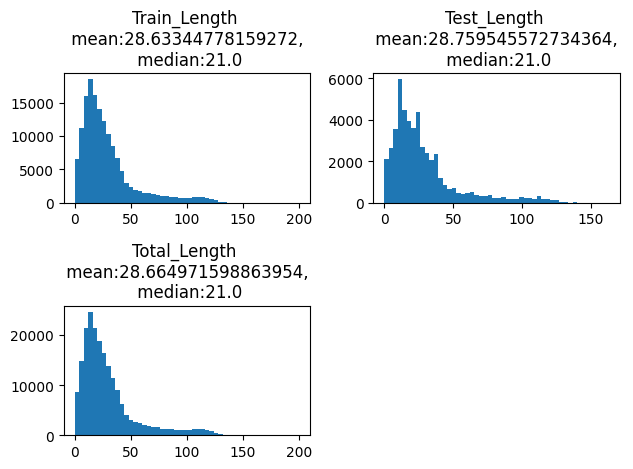

In [14]:
import matplotlib.pyplot as plt
train_length_lst = [len(text) for text in train_sentences] 
test_length_lst = [len(text) for text in test_sentences] 
plt.subplot(2,2,1)
plt.hist(train_length_lst, bins=50)
mean = np.mean(train_length_lst)
median = np.median(train_length_lst)
plt.title(f"Train_Length \n mean:{mean}, \n median:{median}")
plt.subplot(2,2,2)
plt.hist(test_length_lst, bins=50)
mean = np.mean(test_length_lst)
median = np.median(test_length_lst)
plt.title(f"Test_Length \n mean:{mean}, \n median:{median}")
plt.subplot(2,2,3)
plt.hist(train_length_lst+test_length_lst, bins=50)
mean = np.mean(train_length_lst+test_length_lst)
median = np.median(train_length_lst+test_length_lst)
plt.title(f"Total_Length \n mean:{mean}, \n median:{median}")
plt.tight_layout()

In [15]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train['label'], test_size = 0.2)

total_sentences = train_sentences + val_sentences + test_sentences
num_words = 20000
padding = 'post'
truncating = "post"
oov_token = "<OOV>"
one_hot = False
max_len = 15

# Tokenizer 생성 및 문장 학습
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
total_sentences = tokenizer.texts_to_sequences(total_sentences)
padded = pad_sequences(total_sentences, maxlen=max_len, padding=padding, truncating=truncating)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

print(padded.shape)

2024-11-14 18:04:02.640852: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 18:04:02.662493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 18:04:04.031673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(199992, 15)


In [16]:
X_train = np.array(padded[:len(train_sentences)])
y_train = np.array(train_labels)
X_val = np.array(padded[len(train_sentences):len(train_sentences)+len(val_sentences)])
y_val = np.array(val_labels)
X_test = np.array(padded[len(train_sentences)+len(val_sentences):])
y_test = np.array(test['label'])

In [17]:
from sklearn.model_selection import train_test_split
# Train, validation, test dataset 생성 및 배치 단위로 분리
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2024-11-14 18:04:08.513876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:08.543643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:08.543699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:08.552015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:04:08.552095: I tensorflow/compile

In [18]:
from tensorflow.keras import layers, models
import tensorflow as tf

# return_sequence = false, return_state = false
def rnn_model(vocab_size, dim_lst, loss_fn, optimizer, metrics):
    # 입력 레이어
    inputs = layers.Input(shape=(None,), dtype="int32")  # 입력의 모양을 지정 (단어 인덱스 시퀀스)
    x = layers.Embedding(vocab_size + 1, dim_lst[0])(inputs)  # 어휘 크기 + 1, 임베딩 차원 64
    x = layers.LSTM(dim_lst[1])(x)
    x = layers.Dense(dim_lst[2], activation='relu')(x)
    outputs = layers.Dense(dim_lst[3], activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
    return model

# 모델 생성
vocab_size = num_words  # 예시로 어휘 크기 설정
dim_lst = [128, 128, 64, 1]
loss_fn = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model = rnn_model(
    vocab_size=vocab_size, dim_lst=dim_lst, loss_fn=loss_fn, optimizer=optimizer, metrics=metrics
)

# 모델 요약 출력
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2700033 (10.30 MB)
Trainable params: 2700033 (10.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
import time
# 모델 학습 시간 측정
start_time = time.time()

# 모델 학습 (검증 데이터 포함)
epochs = 2
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)

# 모델 테스트 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
end_time = time.time()
evaluation_time = end_time - start_time
print(f"Evaluation Time: {evaluation_time:.2f} seconds")

Epoch 1/2


2024-11-14 18:04:12.754333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-14 18:04:12.777048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-14 18:04:12.800849: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9b1d6737d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 18:04:12.800894: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-14 18:04:12.806921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 18:04:12.885475: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

938/938 [==============================] - 70s 72ms/step - loss: 0.4165 - accuracy: 0.8013 - val_loss: 0.3748 - val_accuracy: 0.8264
Epoch 2/2
391/391 [==============================] - 2s 4ms/step - loss: 0.4038 - accuracy: 0.8239
Test Loss: 0.4038, Test Accuracy: 0.8239
Evaluation Time: 81.59 seconds


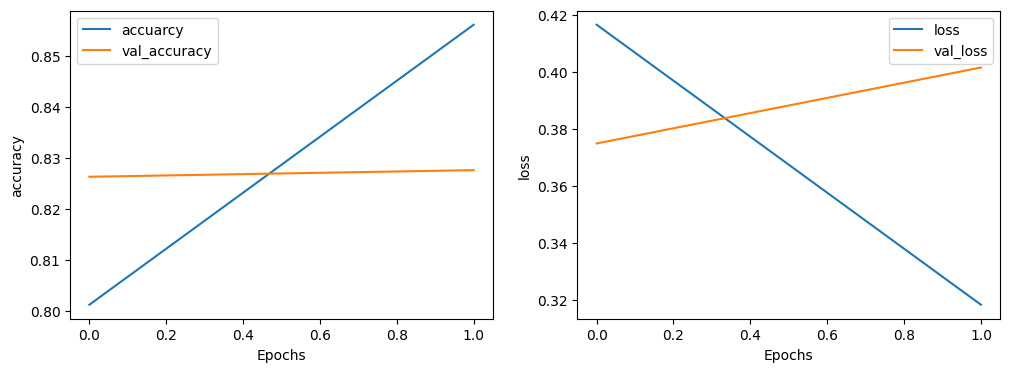

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()